# Collaborative Filtering mit NCF

In [ ]:
import numpy as np
import polars as pl
import hyperparameter_opt
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from ncf_training.trainer.utils.ncf import NCF
from utils.interactions_dataset import InteractionsDataset
from matplotlib import pyplot as plt

/Users/finnhertsch/projects/explo_model/models/cf_ncf/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Datenvorbereitung

#### 1.1 Datenaufbereitung

In [2]:

data = pl.read_csv("data/ncf_data_v1.csv")
data = data.drop_nulls()
data = data.sample(n=1_000_000, seed=42)
print(data["user_pseudo_id"].n_unique(), "unique users")
print(data["article_id"].n_unique(), "unique items")
print(data.shape, "rows in the dataset")

568770 unique users
27948 unique items
(1000000, 2) rows in the dataset


#### 1.2 Trainings & Testdaten

In [3]:
train_df, test_df = train_test_split(data.to_pandas(), test_size=0.2, random_state=42)

train_df = pl.from_pandas(train_df)
test_df = pl.from_pandas(test_df)

print("Training DataFrame:")
print(train_df.shape)

print("\nTest DataFrame:")
print(test_df.shape)

Training DataFrame:
(800000, 2)

Test DataFrame:
(200000, 2)


#### 1.3 Konvertierung zu PyTorch Tensoren

In [4]:
train_dataset = InteractionsDataset(train_df)
test_dataset = InteractionsDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

num_users = len(train_dataset.user_id_map)
num_items = len(train_dataset.item_id_map)
print(f"Number of users: {num_users}\nNumber of items: {num_items}")

Number of users: 483638
Number of items: 24432


## 2. Modelltraining

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NCF(num_users, num_items, embedding_dim=32, layers=[128, 64, 32]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

num_epochs = 10
epoch_data = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for user_idxs, item_idxs in train_loader:
        user_idxs_pos, item_idxs_pos = user_idxs.to(device), item_idxs.to(device)
        labels_pos = torch.ones(len(user_idxs_pos), device=device)

        neg_items = torch.randint(0, num_items, size=(len(user_idxs) * 4,), device=device)
        user_idxs_neg = user_idxs.repeat_interleave(4).to(device)
        item_idxs_neg = neg_items.to(device)
        labels_neg = torch.zeros(len(user_idxs_neg), device=device)

        combined_user_idxs = torch.cat([user_idxs_pos, user_idxs_neg], dim=0)
        combined_item_idxs = torch.cat([item_idxs_pos, item_idxs_neg], dim=0)
        combined_labels = torch.cat([labels_pos, labels_neg], dim=0)

        optimizer.zero_grad()
        outputs = model(combined_user_idxs, combined_item_idxs)
        loss = criterion(outputs.view(-1), combined_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    epoch_data.append(total_loss / len(train_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

Epoch [1/10], Loss: 0.2584
Epoch [2/10], Loss: 0.1625
Epoch [3/10], Loss: 0.1584
Epoch [4/10], Loss: 0.1561
Epoch [5/10], Loss: 0.1530
Epoch [6/10], Loss: 0.1490
Epoch [7/10], Loss: 0.1440
Epoch [8/10], Loss: 0.1386
Epoch [9/10], Loss: 0.1327
Epoch [10/10], Loss: 0.1260


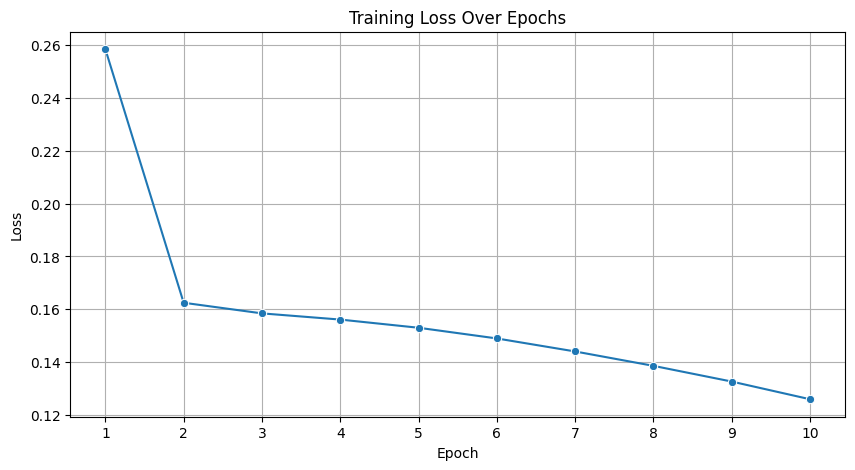

In [6]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, num_epochs + 1), y=epoch_data, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))
plt.grid()
plt.show()

## 3. Evaluierung auf Basis des nDCG@10

In [7]:
def dcg_at_k(scores, k=10):
    """Calculate Discounted Cumulative Gain (DCG) at k."""
    if len(scores) == 0:
        return 0.0
    scores = np.array(scores[:k])  # Ensure scores is a numpy array
    return np.sum((2**scores - 1) / np.log2(np.arange(2, scores.size + 2)))

def ndcg_at_k(truth, scores, k=10):
    """Calculate Normalized Discounted Cumulative Gain (nDCG) at k."""
    best_dcg = dcg_at_k(sorted(truth, reverse=True), k)
    actual_dcg = dcg_at_k([truth[i] for i in np.argsort(scores)[::-1]], k)
    return actual_dcg / best_dcg if best_dcg > 0 else 0

user_id_map = train_dataset.user_id_map
item_id_map = train_dataset.item_id_map

train_df = train_df.with_columns(
    pl.col("user_pseudo_id").map_elements(lambda x: user_id_map.get(x), return_dtype=pl.Int64).alias("user_id_map"),
    pl.col("article_id").map_elements(lambda x: item_id_map.get(x), return_dtype=pl.Int64).alias("item_id_map")
)

test_df = test_df.with_columns(
    pl.col("user_pseudo_id").map_elements(lambda x: user_id_map.get(x), return_dtype=pl.Int64).alias("user_id_map"),
    pl.col("article_id").map_elements(lambda x: item_id_map.get(x), return_dtype=pl.Int64).alias("item_id_map")
)

test_users = test_df["user_id_map"].unique()
user_history_df = train_df.group_by("user_id_map").agg(
    pl.col("item_id_map").alias("item_id_map_list")
)
user_history = dict(zip(user_history_df["user_id_map"], user_history_df["item_id_map_list"]))

model.eval()
ndcg_scores = []
with torch.no_grad():
    for user_id in test_users:
        if user_id is None:
            continue
        pos_items = test_df.filter(pl.col("user_id_map") == user_id)["item_id_map"].to_list()
        pos_items = [item for item in pos_items if item is not None]

        if not pos_items:
            continue

        user_interacted_items = set(user_history.get(user_id, []))

        neg_items = []
        while len(neg_items) < 99:
            neg_item = np.random.randint(0, num_items -1)
            if neg_item not in user_interacted_items and neg_item not in pos_items and neg_item not in neg_items:
                neg_items.append(neg_item)

        all_items = pos_items + neg_items

        true_scores = np.zeros(len(all_items))
        true_scores[:len(pos_items)] = 1

        user_tensor = torch.LongTensor([user_id] * len(all_items)).to(device)
        item_tensor = torch.LongTensor(all_items).to(device)

        scores = model(user_tensor, item_tensor).cpu().numpy().flatten()

        ndcg_scores.append(ndcg_at_k(true_scores, scores, k=10))

average_ndcg = np.mean(ndcg_scores)
print(f"Mean nDCG@10: {average_ndcg:.4f}")

Mean nDCG@10: 0.7469
